In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV,LogisticRegression
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.cluster import KMeans
import random
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

from scipy.stats import bernoulli

from scipy.special import expit

from gurobipy import *

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Default parameters

In [2]:
# number of items:
n = 20

# number of features:
d = 5

# number of observations for each item:
obs = 10

# number of clusters:
z = 2

# number of trials:
T = 100

# noise
sigma = 1

# prob of department level features:
p = 2/3

#probability of cluster level features:
q = 1/6

# Model with Benchmarks

In [3]:
def fit_classification_simulation(Ru,Rl,method="bfgs"):
    
    auc_alg_t, auc_b1_t, auc_b2_t, auc_lasso_t, auc_clus_t,auc_true_t =  np.zeros(T), np.zeros(T),np.zeros(T), np.zeros(T), np.zeros(T),np.zeros(T)
    
    
    #Generation of the classicatin dataset
    
    flag = False
    for t in range(T):
        while not flag: #we need to generate data that have both labels 0 and 1 for each item
        
            # generate random data
            data = np.random.rand(n*obs,d)
            data_test = np.random.rand(int(n*obs/2),d)

            # generate clusters and betas
            feature_dict = {}
            clus_dict = {} # might not be used depending on the feature dict

            for i in range(d):
                # whether this feature should be estimated at the department level
                feature_dict[i] = np.random.choice(['dept', 'clus', 'sku'], p = [p, q, 1-p-q])
            

            items = set(range(n))

            for i in range(z):
                clus_items = random.sample(items,int(n/z))
                clus_dict[i] = clus_items
                items = items - set(clus_items)

            # generate Beta
            beta_dict = {}
            num_cols = 0
            for i in range(d):
                if feature_dict[i] == 'dept':
                    beta_dict[i] = (np.random.random_sample() - 0.5) * 10
                    num_cols += 1
                elif feature_dict[i] == 'clus':
                    beta_dict[i] = (np.random.random_sample(size = z) - 0.5) * 10
                    num_cols += z
                else:
                    beta_dict[i] = (np.random.random_sample(size = n) - 0.5) * 10
                    num_cols += n

            X_true = np.zeros((n*obs, num_cols))
            X_test = np.zeros((int(n*obs/2), num_cols))

            beta = np.zeros(num_cols)
            count = 0
            for i in range(d):
                if feature_dict[i] == 'dept':
                    beta[count] = beta_dict[i]
                    X_true[:,count] = data[:,i]
                    X_test[:,count] = data_test[:,i]

                    count += 1

                elif feature_dict[i] == 'clus':
                    for j in range(z):
                        clus_items = clus_dict[j]
                        for sku in clus_items:
                            X_true[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                            X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]

                        beta[count] = beta_dict[i][j]
                        count += 1
                else:
                    for j in range(n):
                        X_true[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]
                        X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]
                        beta[count] = beta_dict[i][j]
                        count += 1
            
            mu = np.dot(X_true, beta)
            mu_test = np.dot(X_test, beta)
            
            #generate the label from a bernoulli distribution with p = logit(X*beta)
            y = bernoulli.rvs(size=len(mu),p=expit(mu)) 
            y_test = bernoulli.rvs(size=len(mu_test),p=expit(mu_test))
            
            #we are going to test if some features only have labels 1 or 0 and repeat 
            #the data generation until we have balanced generated data
            c= 0
            for i in range(n):
                if np.mean(y[i*obs:(i+1)*obs])*(1-np.mean(y[i*obs:(i+1)*obs]))==0:
                    c +=1
            if c==0:
                break
        
        
    
        #BENCHMARK OF MODELS:
        
        #DECENTRALIZED
        
        y_pred = []
        logit_models = {}
        for i in range(n):

            logit_models[i] = sm.Logit(y[i*obs:(i+1)*obs],data[i*obs:(i+1)*obs,:]).fit(method=method,maxiter=100)
            y_pred += list(logit_models[i].predict(data_test[int(i*obs/2):int((i+1)*obs/2),:]))

        auc_b1_t[t] = roc_auc_score(y_test,np.array(y_pred))
        
        
        #DAC DATA AGGREGATION with CLUSTERING 
        
        aggre_level = []
        clus_columns = []
        all_coeff = np.zeros((n,d))
        all_coeff[0,:] = logit_models[0].params
        n_cols_alg = 0

        for j in range(d):

            # a n-1 vector recording if two betas have the same mean
            test_j = np.zeros(n-1)

            for i in range(1,n):
                #statistical test is that coefficient are different:
                
                all_coeff[i,j] = logit_models[i].params[j]
                # statisticals test to evaluate if the coefficient evaluated by the decentralized model are similar enough or not
                z_stat = ( np.abs(logit_models[0].params[j] - logit_models[i].params[j]) / 
                          np.sqrt(np.square(logit_models[0].bse[j]) + np.square(logit_models[i].bse[j])) )
                p_value = 1 - norm.cdf(z_stat)
                
                if p_value >= 0.05:  
                    test_j[i-1] = 1

            if np.sum(test_j) >= Ru*(n-1): #if null hypothesis rejected more than Ru times: feature at the department level
                aggre_level.append('dept')
                n_cols_alg += 1

            elif np.sum(test_j) <= Rl*(n-1): #if null hypothesis can't be rejected more than Rl times: feature at the sku level
                aggre_level.append('sku')
                n_cols_alg += n

            else:
                aggre_level.append('clus') #elese: feature will be evaluated at a cluster level

                clus_columns.append(j)
                n_cols_alg += z

        if len(clus_columns) > 0:
            X_clus = all_coeff[:, clus_columns]
            kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

        X_alg = np.zeros((n*obs, n_cols_alg))
        X_test = np.zeros((int(n*obs/2), n_cols_alg))

        count = 0
        
        for i in range(d):
            if aggre_level[i] == 'dept':
                X_alg[:,count] = data[:,i]
                X_test[:,count] = data_test[:,i]
                count += 1

            elif aggre_level[i] == 'clus':
                for j in range(z):
                    clus_items = list(np.where(kmeans.labels_ == j)[0])
                    for sku in clus_items:
                        X_alg[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                        X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]


                    count += 1
            else:
                for j in range(n):
                    X_alg[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]
                    X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]
                    count += 1
                    
                    
        model_0 = sm.Logit(y,X_alg).fit(method=method,maxiter=100)
        auc_alg_t[t] = roc_auc_score(y_test,model_0.predict(X_test))
        
        
        # CENTRALIZED
        
        model_0 = sm.Logit(y,data).fit(method=method,maxiter=100)
        auc_b2_t[t] = roc_auc_score(y_test,model_0.predict(data_test))
        

        # CLUSTER 
        
        X_clus = np.zeros((n, d))
        count = 0
        y_pred = np.zeros(int(n*obs/2))
        for i in range(n):
            #cluster the item based on the mean of the value of 
            X_clus[count, :] = np.mean(data[i*obs:(i+1)*obs,:], axis = 0) 
            count += 1
        
        kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
        for i in range(z):
            clus_items = list(np.where(kmeans.labels_ == i)[0])
            base_rows = np.array(list(range(obs)))
            base_rows_test = np.array(list(range(int(obs/2))))
            rows = []
            test_rows = []
            for j in clus_items:
                rows += list(range( j*obs, (j+1)*obs ))
                test_rows += list(range( j*int(obs/2), (j+1)*int(obs/2) ))
            
            model_i = sm.Logit(y[np.ix_(rows)], data[np.ix_(rows)]).fit(method=method,maxiter=100)
            y_pred[np.ix_(test_rows)] = model_i.predict(data_test[np.ix_(test_rows)])

        auc_clus_t[t] = roc_auc_score(y_test,np.array(y_pred))
        
        
    return(np.mean(auc_alg_t),np.mean(auc_b1_t),np.mean(auc_b2_t),np.mean(auc_clus_t),np.mean(auc_true_t))
        

In [4]:
fit_classification_simulation(0.9,0.2)

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.357043
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.425680
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.554832
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.537317
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.532883
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.537951
         Iterations: 34
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.598319
         Iterations: 80
         Function evaluations: 81
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 0.625384
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.616529
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.607542
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 28
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.569669
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.600974
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.595671
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.587108
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 46
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.169601
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.535960
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.552715
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.477861
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.289471
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
         Current function value: 0.057418
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.412209
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.312526
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 55
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000522
         Iterations: 54
         Function evaluations: 55
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.474303
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.386638
         Iterations: 42
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.466601
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.547758
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.437803
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 36
         Function evaluations: 37
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.493429
         Iterations: 86
         Function evaluations: 88
         Gradient evaluations: 88
Optimization terminated successfully.
         Current function value: 0.503805
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.533774
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.464106
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.299048
         Iterations: 51
         Function evaluations: 52
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.113739
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.480713
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.469995
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.456469
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.367307
         Iterations: 44
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.498396
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 31
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.330714
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.486949
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.298146
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.613830
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.333358
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.498053
         Iterations: 38
         Function evaluations: 39
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.456845
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.474981
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.441892
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.493901
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.317381
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.086783
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.559808
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.378025
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.516108
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 44
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.234726
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.585554
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.526435
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.624688
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.349521
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 0.191225
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.503933
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 52
         Function evaluations: 53
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.327779
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.339222
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.388468
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.420986
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.442311
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.403724
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.422879
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.453104
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.558166
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.572291
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.538045
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.595030
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.350678
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.416976
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 44
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.533634
         Iterations: 53
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.571638
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.506647
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.598454
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.371671
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.404532
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.159407
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.445291
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.083604
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.408291
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.419067
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.394702
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.192530
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.453273
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.454816
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.434614
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.484941
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.476027
         Iterations: 76
         Function evaluations: 77
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: 0.492814
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.484469
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.462327
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.540107
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.476840
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.515924
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.489470
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.499191
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.122116
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.473574
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.495081
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.421320
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.644730
         Iterations: 90
         Function evaluations: 92
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.676267
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.517494
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.671755
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.621904
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 38
         Function evaluations: 39
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.546367
         Iterations: 97
         Function evaluations: 99
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 0.581594
         Iterations: 23
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.320613
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.429729
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.532828
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.466815
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.464377
         Iterations: 45
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.145256
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.483503
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.474731
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.477057
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.106998
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.445201
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.434494
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.438306
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000092
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.390645
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.401863
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.324321
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.225963
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.279828
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.462911
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.327019
         Iterations: 42
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.504760
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.512678
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.452198
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.518075
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.495488
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.521192
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.386131
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 44
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.320108
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.277123
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.327182
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.355867
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.480174
         Iterations: 93
         Function evaluations: 94
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 0.488980
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.513016
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.461122
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.599680
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.422236
         Iterations: 38
         Function evaluations: 39
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.560264
         Iterations: 82
         Function evaluations: 83
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: 0.589818
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.597408
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.564434
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 18
         Function evaluations: 19
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.259979
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.380863
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         C

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.504244
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.316284
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  

Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.457794
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.363845
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 63
         Function evaluations: 66
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.537051
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.116157
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.551226
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.554611
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.457499
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.531200
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 63
         Function evaluations: 64
         Gradient evaluations: 64
         Current function value: 0.586484
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.601821
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.573702
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.597427
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 60
         Function evaluations: 61
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.131871
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.496922
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.404355
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.518228
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.300763
         Iterations: 44
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.342336
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 73
         Function evaluations: 75
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.507015
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.523205
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.521361
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.503788
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.409820
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.530657
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.350927
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', H

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 56
         Function evaluations: 58
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

         Current function value: 0.558483
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.598167
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.590639
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.577350
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.404419
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 75
         Function evaluations: 76
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.000074
         Iterations: 71
         Function evaluations: 72
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.377578
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.320322
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimi

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.430058
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
         Current function value: 0.184053
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.510041
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.387152
         Iterations: 39
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.438166
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.471631
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.362752
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.363143
         Iterations: 45
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         C

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.456744
         Iterations: 68
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.467640
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.413622
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.515809
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin


         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.556435
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.418071
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
 

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.212814
         Iterations: 52
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.422686
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.390328
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.411966
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.409247
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 0.127154
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.355230
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.351424
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.344415
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 54
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.365758
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
         Current function value: 0.549378
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.585086
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.609067
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.528964
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.437264
         Iterations: 84
         Function evaluations: 85
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 0.465925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.446422
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.480518
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.446788
         Iterations: 38
         Function evaluations: 39
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.376157
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.474800
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 61
         Function evaluations: 63
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.242435
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 56
         Function evaluations: 57
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.112206
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.484685
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.485752
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.418996
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 51
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.280700
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.120467
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.400410
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.382782
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 43
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.371151
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.227773
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.583730
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.577051
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.558711
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.471672
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.391340
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.626857
         Iterations: 89
         Function evaluations: 90
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.655729
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.605057
         Iterations: 31
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.480770
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.326682
         Iterations: 48
         Function evaluations: 49
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.525707
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.353278
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.291619
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.304605
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.347923
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.302250
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.389071
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.489929
         Iterations: 36
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.400799
         Iterations: 93
         Function evaluations: 94
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 0.424756
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.432466
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.386036
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.578087
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.494805
         Iterations: 84
         Function evaluations: 85
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 0.523120
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.535040
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.474242
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.454576
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.466246
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.093879
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.588624
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.548073
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.541768
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.558791
         Iterations: 82
         Function evaluations: 83
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: 0.588805
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.580207
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.509661
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.143489
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.488398
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.249569
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.575714
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.097758
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.598031
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.562194
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.223370
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 49
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.620461
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.439963
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.462703
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.459265
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.442212
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.417604
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.321577
         Iterations: 45
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.374294
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.439340
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.591305
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.556106
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.532671
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 56
         Function evaluations: 58
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.555406
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.560812
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.521126
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.106656
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.302690
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.343084
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.198082
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.114624
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.419472
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.405302
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.421638
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 42
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 52
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.362269
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
         Current function value: 0.157620
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.542497
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.520088
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.346471
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.429404
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 31
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 65
         Function evaluations: 66
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 60
         Function evaluations: 61
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0.7496841201547711,
 0.6943175736063654,
 0.7919726225787384,
 0.7889357608576293,
 0.0)

# Example INCREASE NUMBER OF ITEMS

In [5]:
list_n = [i for i in range(10,30,5)]


auc_alg, auc_b1, auc_b2, auc_clus = [], [], [], []
for n in list_n:
    result_1, result_2, result_3, result_4,result_5 = fit_classification_simulation(0.9,0.6,"bfgs")
    auc_alg.append(result_1)
    auc_b1.append(result_2)
    auc_b2.append(result_3)
    auc_clus.append(result_4)
    print("dac",result_1)
    print("dec",result_2)
    print("items:",n)


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.429610
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.443859
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.579580
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.583455
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.292495
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.157698
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.516790
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.459100
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.545571
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 31
         Function evaluations: 32
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.107384
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.454349
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.327094
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.490517
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.051244
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.485881
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.397124
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.586733
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.593951
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.226949
         Iterations: 52
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.422049
         Iterations: 41
         Function evaluations: 42
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.433474
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.514288
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.552779
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.454981
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.504894
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.410610
         Iterations: 83
         Function evaluations: 84
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: 0.453737
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.312626
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.477420
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.086717
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.530945
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.389676
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.494363
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.415649
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 53
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.427864
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.327970
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
         Current function value: 0.193557
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.422753
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.520243
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.293690
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.551795
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.508432
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.525440
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.209963
         Iterations: 66
         Function evaluations: 67
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.306205
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.483243
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.555276
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.245386
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.340235
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
         Current function value: 0.364328
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.417260
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.097847
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.536374
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.482057
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.557573
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.223376
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000106
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.327943
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.453939
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountere

Optimization terminated successfully.
         Current function value: 0.506492
         Iterations: 80
         Function evaluations: 81
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 0.557022
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.414722
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.595520
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 56
         Function evaluations: 57
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'av

Optimization terminated successfully.
         Current function value: 0.591875
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.311582
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 53
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 49
         Function evaluations: 50
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.450642
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.441852
         Iterations: 68
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.488424
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.408448
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.558549
         Iterations: 36
         Function evaluations: 37
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.086392
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.529791
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.513197
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.527429
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.583764
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.288309
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.323304
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.209948
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.462350
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.279601
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.542528
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

         Current function value: 0.598975
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.664113
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.609533
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.668572
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.505573
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 76
         Function evaluations: 77
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 50
         Function evaluations: 52
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.586512
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.586049
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.562714
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.525844
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.537605
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.145061
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.500236
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.392486
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.557960
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.517606
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.325755
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.378762
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.464401
         Iterations: 84
         Function evaluations: 85
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 0.504497
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.527764
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.411166
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 24
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.048647
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.591233
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.525374
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.605454
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.507450
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.473521
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.372800
         Iterations: 52
         Function evaluations: 53
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.420749
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
      

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.465948
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.458090
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.347948
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma


         Current function value: 0.021590
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.584262
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.319921
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.614197
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Op

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.142366
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.541052
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.456470
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.311375
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.340890
         Iterations: 45
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.486194
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.483749
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 56
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.294401
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.500766
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.325793
         Iterations: 43
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.454438
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.386292
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 38
         Function evaluations: 39
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.096674
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.414772
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.359192
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.455751
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed


         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.510398
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.492100
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 54
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.594206
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.593351
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.463195
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  

         Current function value: 0.389380
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.438304
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.446998
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.417590
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Current function value: 0.077266
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.451765
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.440711
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.336927
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Op

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.368081
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.133500
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.347350
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.194347
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.350118
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.445515
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.118362
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.449509
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

Optimization terminated successfully.
         Current function value: 0.585714
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.513509
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 75
         Function evaluations: 76
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountere

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.336641
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.337870
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.310619
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.116071
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Current function value: 0.065922
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.426438
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.417582
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.502098
         Iterations: 95
         Function evaluations: 96
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 0.569142
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.605267
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.519528
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

Optimization terminated successfully.
         Current function value: 0.482157
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.467860
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.415814
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.382605
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', H

Optimization terminated successfully.
         Current function value: 0.625641
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.609606
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.618216
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.247459
         Iterations: 53
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 31
         Function evaluations: 32
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.029093
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.637122
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.533988
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.625386
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.390152
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
         Current function value: 0.553747
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.578020
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.604789
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.412277
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 61
         Function evaluations: 63
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.168257
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.566496
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.559108
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.520584
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve


         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
         Current function value: 0.103590
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

         Current function value: 0.055379
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.340247
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.369026
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.277149
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.389448
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.617985
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.066384
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.453138
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.072481
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.415198
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.441682
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.340604
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.292316
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.363266
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.044597
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.454143
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.337023
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.447384
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.054628
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.389528
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.202916
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.508591
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.497873
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.495387
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.109626
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.560370
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.505026
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.574628
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.417321
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.422565
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.397156
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.094024
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.490040
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.500483
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.384688
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.482712
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.512139
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.487218
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.496105
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.570646
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.211650
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 51
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 66
         Function evaluations: 68
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: 0.542360
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.370884
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

         Current function value: 0.142567
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.390099
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.325773
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.441033
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.142280
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.437120
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.467928
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.399265
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.428824
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  

Optimization terminated successfully.
         Current function value: 0.568845
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.491899
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 62
         Function evaluations: 63
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.195527
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.645668
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.616765
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.629494
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.479456
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.409993
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 60
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.639755
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.458955
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.166883
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.518372
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.336337
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.542716
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.133677
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.536801
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.474650
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.540864
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.417407
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.343015
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.579608
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 57
         Function evaluations: 60
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.357276
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.337983
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.341314
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
      

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.147368
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.446443
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.527907
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.334904
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.322714
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.256668
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.361856
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.455213
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.405145
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.464510
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.250239
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 22
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.432099
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.419609
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.369141
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.054216
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.513495
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.425430
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.539845
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.512359
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.314287
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.370990
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.575424
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 65
         Function evaluations: 66
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.108627
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.507327
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.490509
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.501309
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 73
         Function evaluations: 75
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 39
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 51
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.346174
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.077758
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.387738
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.378115
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.376888
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.472133
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.422046
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.455822
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.348446
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.481880
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.382943
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.390760
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.441540
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.481394
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.293431
         Iterations: 45
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 36
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.344704
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.460368
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.534741
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.228546
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.558043
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.505695
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 42
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
         Current function value: 0.106669
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.562735
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.540300
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.502488
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.361802
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

Optimization terminated successfully.
         Current function value: 0.265537
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
         Current function value: 0.469498
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.488747
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.496372
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.474267
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.378487
         Iterations: 52
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.433362
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.292655
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.313323
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.532086
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 32
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.198228
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.578747
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.521789
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.596389
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

         Current function value: 0.130838
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.434438
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.426173
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.337729
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.507690
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.549874
         Iterations: 93
         Function evaluations: 95
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: 0.587322
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.585562
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.555844
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.642261
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.632716
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.502320
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.526109
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.423180
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.119323
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.538916
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.476570
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 71
         Function evaluations: 72
         Gradient evaluations: 72
         Current function value: 0.516607
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.554493
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.526598
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.524090
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.546606
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.335654
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'av

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 55
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.485476
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
         Current function value: 0.493783
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.499893
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.484277
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.527607
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

         Current function value: 0.164625
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.582789
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.637406
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.517170
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 37
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.552627
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.279385
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.498997
         Iterations: 91
         Function evaluations: 93
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.544167
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.378869
         Iterations: 99
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.419279
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.416599
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.402212
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 19
         Function evaluations: 21


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.593560
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.495869
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 51
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 27
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.407486
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.470730
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.358066
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 67
         Function evaluations: 69
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 33
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.538226
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.571019
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.535565
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.608109
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.438834
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.491104
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.390635
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.522469
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.419529
         Iterations: 95
         Function evaluations: 96
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 0.462277
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.510534
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.251297
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.391135
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.407375
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

         Current function value: 0.134760
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.374903
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.432226
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.345308
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.523140
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 0.127276
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.455784
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.460808
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.400652
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.121295
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.622887
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.611220
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.458010
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.336150
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.491426
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
         Current function value: 0.132625
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.508386
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.461894
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.596968
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 37
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.498050
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.604222
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.442621
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.371531
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.072693
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.437974
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.414982
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.427905
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.129258
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.575345
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.595488
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.514726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
         Current function value: 0.128096
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.420035
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.383435
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.373394
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.506545
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.597315
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.628087
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.613258
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.611756
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 62
         Function evaluations: 64
         Gradient evaluations: 64
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.080437
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.345298
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.306494
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.362161
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.149806
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.524652
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.516141
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.510329
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.102072
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.444687
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.334707
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.534154
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.055268
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.504988
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.521088
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.345341
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.443034
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.205296
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.501592
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.461651
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.538059
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.149918
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.580957
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.543138
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.595782
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Current function value: 0.148239
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.446292
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.430885
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 51
         Function evaluations: 52
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.316831
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.441977
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 54
         Function evaluations: 58
         Gradient evaluations: 58
         Current function value: 0.550156
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.600232
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', H

Optimization terminated successfully.
         Current function value: 0.551506
         Iterations: 82
         Function evaluations: 83
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: 0.583780
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.585629
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.408243
         Iterations: 36
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 67
         Function evaluations: 69
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.299376
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 64
         Function evaluations: 65
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.481004
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.420640
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.505295
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.105171
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.434200
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.475001
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.362495
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.108598
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.380461
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.294965
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.419790
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.625238
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.587462
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.512561
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

         Current function value: 0.112986
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.599542
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.595522
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.568362
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
dac 0.7331352739679522
dec 0.6893139349272588
items: 15
Optimization terminated successfully.
         Current function value: 0.499919
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Functi

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.124819
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.397876
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.339978
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.408690
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.611627
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.352814
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.581411
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.605479
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.560028
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.605755
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 41
         Function evaluations: 42
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.093150
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.605793
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.648180
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.546914
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

         Current function value: 0.110405
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.499579
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.558386
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.289818
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.463723
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.468150
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.458831
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.418267
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.446805
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.422964
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.433014
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.547540
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.546789
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.534673
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.054592
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.367241
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.292064
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.402405
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.373524
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.396741
         Iterations: 39
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.425026
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 16
         Function evaluations: 18
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.303932
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.396474
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.375359
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.552519
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.554098
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.397785
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.529678
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 24
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.268167
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.454884
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.529801
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.110672
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.452333
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.445539
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.442628
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.430605
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.303432
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.590992
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.488516
         Iterations: 99
         Function evaluations: 100
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.519195
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.453527
         Iterations: 34
         Function evaluations: 36


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 54
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.505863
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.374260
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.335870
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.499480
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.654278
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.669804
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 50
         Function evaluations: 51
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.517442
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 65
         Function evaluations: 67
         Gradient evaluations: 67
         Current function value: 0.408337
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.418551
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.413423
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.413782
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.132184
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.418493
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.408734
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.400168
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.518903
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.471142
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 67
         Function evaluations: 69
         Gradient evaluations: 69
         Current function value: 0.207433
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.586772
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.467740
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.435277
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.303028
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.328569
         Iterations: 44
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.264314
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.296421
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.442699
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.434001
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.423700
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.463262
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.198479
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.596767
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.621709
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.535431
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.493070
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.406062
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.404989
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.385523
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 19
         Function evaluations: 20
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.228890
         Iterations: 60
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 49
         Function evaluations: 50
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.254286
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.588875
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.600887
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.547554
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.170293
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.423695
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.455529
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.358014
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.340448
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.383436
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 63
         Function evaluations: 64
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
         Current function value: 0.188390
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.328216
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.414466
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.451657
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.521404
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.355619
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.587104
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.450709
         Iterations: 96
         Function evaluations: 97
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 0.483408
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.524118
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.347447
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.396138
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.423385
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.384132
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.406064
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 30
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.224923
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.466650
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.450227
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.484996
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.328290
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.444917
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
         Current function value: 0.156182
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.484789
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.441282
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.483913
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 52
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.390477
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.380192
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.435087
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 47
         Function evaluations: 48
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.134437
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.558922
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.505676
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.562101
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.521571
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 18
         Function evaluations: 20
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.467351
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.518199
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.426536
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.482652
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 54
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.322704
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


Optimization terminated successfully.
         Current function value: 0.584342
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.586622
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.384784
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
 

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.180513
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.461504
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.445958
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.456973
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.361902
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.426796
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.396860
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
         Current function value: 0.168727
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.301591
         Iterations: 46
         Function evaluations: 48
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.133164
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.422363
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.296161
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.460696
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



         Current function value: 0.355230
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 62
         Function evaluations: 64
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.542486
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.110572
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.387878
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.374757
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.356223
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 53
         Function evaluations: 55
         Gradient evaluations: 55
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 54
         Function evaluations: 57
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.101193
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.603000
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.582906
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.364212
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.342789
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.121493
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.546731
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.530542
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.525033
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.376929
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.424123
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.178954
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 59
         Function evaluations: 61
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.380263
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 30
         Function evaluations: 32
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.326871
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.513811
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.426677
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.340266
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.485143
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 36
         Function evaluations: 37
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.136914
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.603848
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.458161
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.572659
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.509458
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 18
         Function evaluations: 19
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve


         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.527466
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.499115
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.517756
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.469674
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.505785
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.400847
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.364666
         Iterations: 42
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.561303
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.492158
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.521469
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.428579
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.516710
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.649689
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.670311
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.360095
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.343252
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.405260
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.452452
         Iterations: 76
         Function evaluations: 77
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Current function value: 0.000013
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.184060
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.399916
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.402671
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.426359
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.358148
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
         Current function value: 0.122340
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.390472
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.384245
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.407051
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Current function value: 0.000014
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.078641
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.564599
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.378468
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.621323
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.084569
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.437209
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.447952
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.407937
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.590321
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.114492
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.535891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.517321
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.501640
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 48
         Function evaluations: 50
         Gradient evaluations: 50
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.644826
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 61
         Function evaluations: 64
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.551147
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.339029
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.465770
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 55
         Function evaluations: 56
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.442599
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.451628
         Iterations: 88
         Function evaluations: 90
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.470055
         Iterations: 33
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.490586
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.400021
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.267514
         Iterations: 41
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.450776
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.470794
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.448952
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.477972
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 17
         Function evaluations: 19
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.199875
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.400453
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.090580
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.369266
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.308259
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.358643
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.486605
         Iterations: 97
         Function evaluations: 99
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 0.506010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.551776
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.449336
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 52
         Function evaluations: 53
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.067384
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.408147
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.399800
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.338168
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve


         Current function value: 0.000041
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.143549
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.495525
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.473791
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.453643
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.310752
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.374643
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.350727
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.532916
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.069062
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.123775
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.631942
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.633895
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.622859
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.483056
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.431678
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 39
         Function evaluations: 40
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.469909
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.455390
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.465906
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000081
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.326685
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.306964
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.457864
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.425085
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.472102
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.347959
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.445149
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.458143
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.417531
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.490098
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.141967
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.554512
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.554089
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.531184
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 19
         Function evaluations: 20
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.205713
         Iterations: 53
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.331818
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.535217
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.497773
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed t

Optimization terminated successfully.
         Current function value: 0.258212
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.389707
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.413990
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.469810
         Iterations: 40
         Function evaluations: 41
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 59
         Function evaluations: 63
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.337944
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 40
         Function evaluations: 42
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.563590
         Iterations: 97
         Function evaluations: 98
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 0.589067
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.566769
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.574950
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 42
         Function evaluations: 43
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.608744
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.685491
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.481135
         Iterations: 41
         Function evaluations: 42
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.451727
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

         Current function value: 0.088342
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.567434
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.570809
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.517641
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.561259
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.282364
         Iterations: 53
         Function evaluations: 54
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.634237
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.629482
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.621410
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.646638
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.234011
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.490417
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.545541
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.417283
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.605398
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.598633
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.602641
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.579872
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.196149
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.508240
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.518870
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.490199
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.293489
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.439914
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.366133
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.408708
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.522185
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.554853
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.446674
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.377470
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.305925
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.479186
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.300855
         Iterations: 44
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountere

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.344285
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.179089
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.490228
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.460438
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.551033
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.333778
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.564451
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 19
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.211815
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.523356
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.513626
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.109864
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.466793
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.469503
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.456659
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or


         Current function value: 0.000015
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.342161
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.379910
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.274048
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.139391
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.368483
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.226313
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.411628
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.288726
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 47
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.148663
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.424772
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.353906
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.445546
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.325593
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.133005
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.418417
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.409659
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.421849
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.347101
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 29
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 52
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.301303
         Iterations: 44
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.572622
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.621081
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.511242
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.116626
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.519913
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.477916
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 61
         Function evaluations: 62
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.409488
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.488456
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

         Current function value: 0.103054
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.607277
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.570738
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.656408
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.469893
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.494087
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.482303
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.295234
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.347655
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 50
         Function evaluations: 51
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.563226
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.577619
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.173866
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.441408
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.404050
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.503556
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.104384
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.440174
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.400271
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.438406
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.354256
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.318986
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.342743
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 47
         Function evaluations: 48
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.120266
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.396240
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.339590
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.420097
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 29
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.413954
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.446755
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.443791
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.129638
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.592611
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.540070
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.591670
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.410607
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.432184
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
         Current function value: 0.251408
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.539417
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.551095
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.509631
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.560476
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 73
         Function evaluations: 74
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.301696
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 25
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 55
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 80
         Function evaluations: 82
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.173960
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.433532
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.370437
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.484646
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.332532
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Current function value: 0.084660
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.415177
         Iterations: 44
         Function evaluations: 45
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.146864
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.458119
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.354834
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.469888
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Current function value: 0.439533
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.434014
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.326076
         Iterations: 42
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.386309
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.271978
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 34
         Function evaluations: 35
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 63
         Function evaluations: 65
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.155362
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.413293
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.441827
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.379009
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 55
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.526104
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.197473
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.439916
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 53
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.350078
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountere

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

         Current function value: 0.123872
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.504125
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.500989
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.474595
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.070624
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.388939
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.439274
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.321506
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 61
         Function evaluations: 63
         Gradient evaluations: 63
         Current function value: 0.169294
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.472891
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.504256
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.432135
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 67
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.335826
         Iterations: 48
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.367299
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.438384
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.434317
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 0.127579
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.378046
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.394788
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.282971
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000156
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.178445
         Iterations: 57
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 19
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

         Current function value: 0.128083
         Iterations: 100
         Function evaluations: 104
         Gradient evaluations: 104
Optimization terminated successfully.
         Current function value: 0.385822
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.350635
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.389229
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.452170
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.361997
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 18
         Function evaluations: 20
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeW

Optimization terminated successfully.
         Current function value: 0.517724
         Iterations: 91
         Function evaluations: 93
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.545136
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.545993
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.536227
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
         Current function value: 0.176953
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.462409
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.375747
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.442789
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.421921
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.311169
         Iterations: 46
         Function evaluations: 47
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
         Current function value: 0.214998
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.512029
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.466729
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.241823
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.549662
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.549731
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.529776
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.314394
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.293741
         Iterations: 47
         Function evaluations: 49
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.413705
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.392047
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.301794
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 21
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.149453
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.477681
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.499744
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.439104
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.440657
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.594177
         Iterations: 37
         Function evaluations: 38
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Ma

Optimization terminated successfully.
         Current function value: 0.495713
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.473400
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.323166
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.476948
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.328318
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.089402
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.416462
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.362062
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.435065
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.438626
         Iterations: 44
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.490783
         Iterations: 81
         Function evaluations: 84
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: 0.494504
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.469784
         Iterations: 31
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.366090
         Iterations: 45
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.246685
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.580437
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.496749
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.185100
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.480930
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.456456
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.490524
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 64
         Function evaluations: 66
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.113627
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.507845
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 52
         Function evaluations: 54
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.346860
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 29
         Function evaluations: 31
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve


         Current function value: 0.000012
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 73
         Function evaluations: 75
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optim

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.148018
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.466333
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.455388
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.460093
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 33
         Function evaluations: 34
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.423395
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.525712
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.499194
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.530766
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 24
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.311610
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.453801
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.586734
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 28
         Function evaluations: 30
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.161203
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.436904
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.474360
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.406379
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.490935
         Iterations: 97
         Function evaluations: 100
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.516062
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.531370
         Iterations: 26
         Function evaluations: 27


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.276711
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 53
         Function evaluations: 54
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.224099
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 25
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.384741
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.407073
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.447896
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.375989
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.276021
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000078
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 54
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.477108
         Iterations: 94
         Function evaluations: 95
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Current function value: 0.541160
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.562688
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.513343
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.322063
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 30
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 32
         Function evaluations: 33
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.446586
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.431465
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 36
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.591388
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.220098
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.606335
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.566557
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.604366
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.545323
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.503765
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.317110
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.425448
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.254479
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.341790
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 20
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:173

Optimization terminated successfully.
         Current function value: 0.453716
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.454708
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.398938
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.291880
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.189915
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.489529
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.408290
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.462838
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.299476
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 43
         Function evaluations: 44
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed


Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.608526
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.388255
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.462052
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 24
 

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 41
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.403565
         Iterations: 89
         Function evaluations: 90
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.407812
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.388853
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.401628
         Iterations: 36
         Function evaluations: 37
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.569314
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 22
         Function evaluations: 23
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 21
         Function evaluations: 22
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.365157
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 51
         Current function value: 0.234648
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.551445
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.511715
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.564691
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.226735
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 28
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

Optimization terminated successfully.
         Current function value: 0.506304
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.391112
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 44
         Function evaluations: 46
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.345073
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.563197
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 48
         Function evaluations: 49
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.363906
         Iterations: 39
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 27
         Function evaluations: 28
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

         Current function value: 0.161702
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.411426
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.472726
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.331629
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.096100
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInve

Optimization terminated successfully.
         Current function value: 0.396590
         Iterations: 43
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 53
         Function evaluations: 55
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 35
         Function evaluations: 36
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarnin

Optimization terminated successfully.
         Current function value: 0.447523
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.534492
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 27
         Function evaluations: 29
  

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

         Current function value: 0.088050
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: 0.589023
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.590763
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.569309
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.270651
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.276202
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.275760
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.261391
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.500878
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Opt

/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed

         Current function value: 0.504029
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.517754
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.535916
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.451048
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
dac 0.7617914084703901
dec 0.7002337484224774
items: 25


/Users/arthur.pentecoste/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


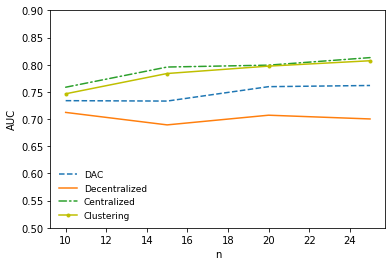

In [6]:
plt.plot(list_n, auc_alg,"--",label = 'DAC')
plt.plot(list_n, auc_b1,'',label = 'Decentralized')
plt.plot(list_n, auc_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_n, auc_clus,'y-o',markersize=3,label = 'Clustering')

plt.legend(loc='best',frameon=False,prop={'size': 9})
plt.xlabel('n')
plt.ylabel('AUC')
plt.ylim(0.5,0.9)
plt.show()